In [179]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
from sklearn import model_selection
import copy

# Load data

In [180]:
# Mikel path
df = pd.read_csv('/Users/mikelyu/Desktop/Uni/02455 Statistical Evaluation/02455-projects/HR_data.csv')

# Karl path
#df = pd.read_csv(r"C:\desktop\02455-projects\HR_data.csv")

print(df.head())

   Unnamed: 0    HR_Mean  HR_Median    HR_std  HR_Min  HR_Max     HR_AUC  \
0           0  77.965186      78.00  3.345290   73.23   83.37  22924.945   
1           1  70.981097      70.57  2.517879   67.12   78.22  21930.400   
2           2  73.371959      73.36  3.259569   67.88   80.22  21647.085   
3           3  78.916822      77.88  4.054595   72.32   84.92  25258.905   
4           4  77.322226      74.55  6.047603   70.52   90.15  23890.565   

     Round   Phase  Individual  Puzzler  Frustrated Cohort  
0  round_3  phase3           1        1           1   D1_1  
1  round_3  phase2           1        1           5   D1_1  
2  round_3  phase1           1        1           0   D1_1  
3  round_2  phase3           1        1           1   D1_1  
4  round_2  phase2           1        1           5   D1_1  


No missing values.

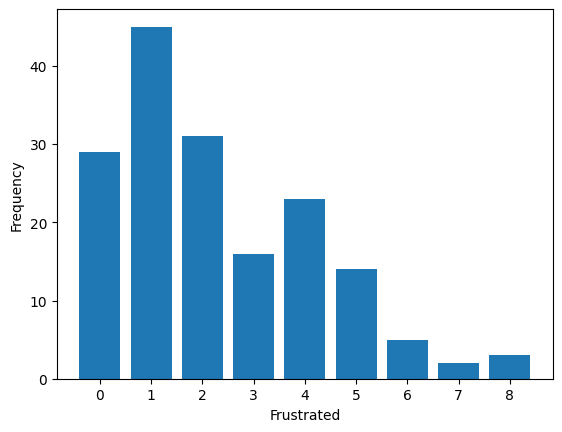

In [181]:
min_value = df['Frustrated'].min()
max_value = df['Frustrated'].max()
bin_edges = np.arange(min_value - 0.5, max_value + 1.5, 1)  # Add and subtract 0.5 to center bins

# Create the histogram with customized settings
plt.hist(df['Frustrated'], bins=bin_edges, align='mid', rwidth=0.8)  # Adjust rwidth for spacing

# Customize tick marks and labels
plt.xticks(range(min_value, max_value + 1)) 
plt.xlabel('Frustrated')
plt.ylabel('Frequency')
plt.show()

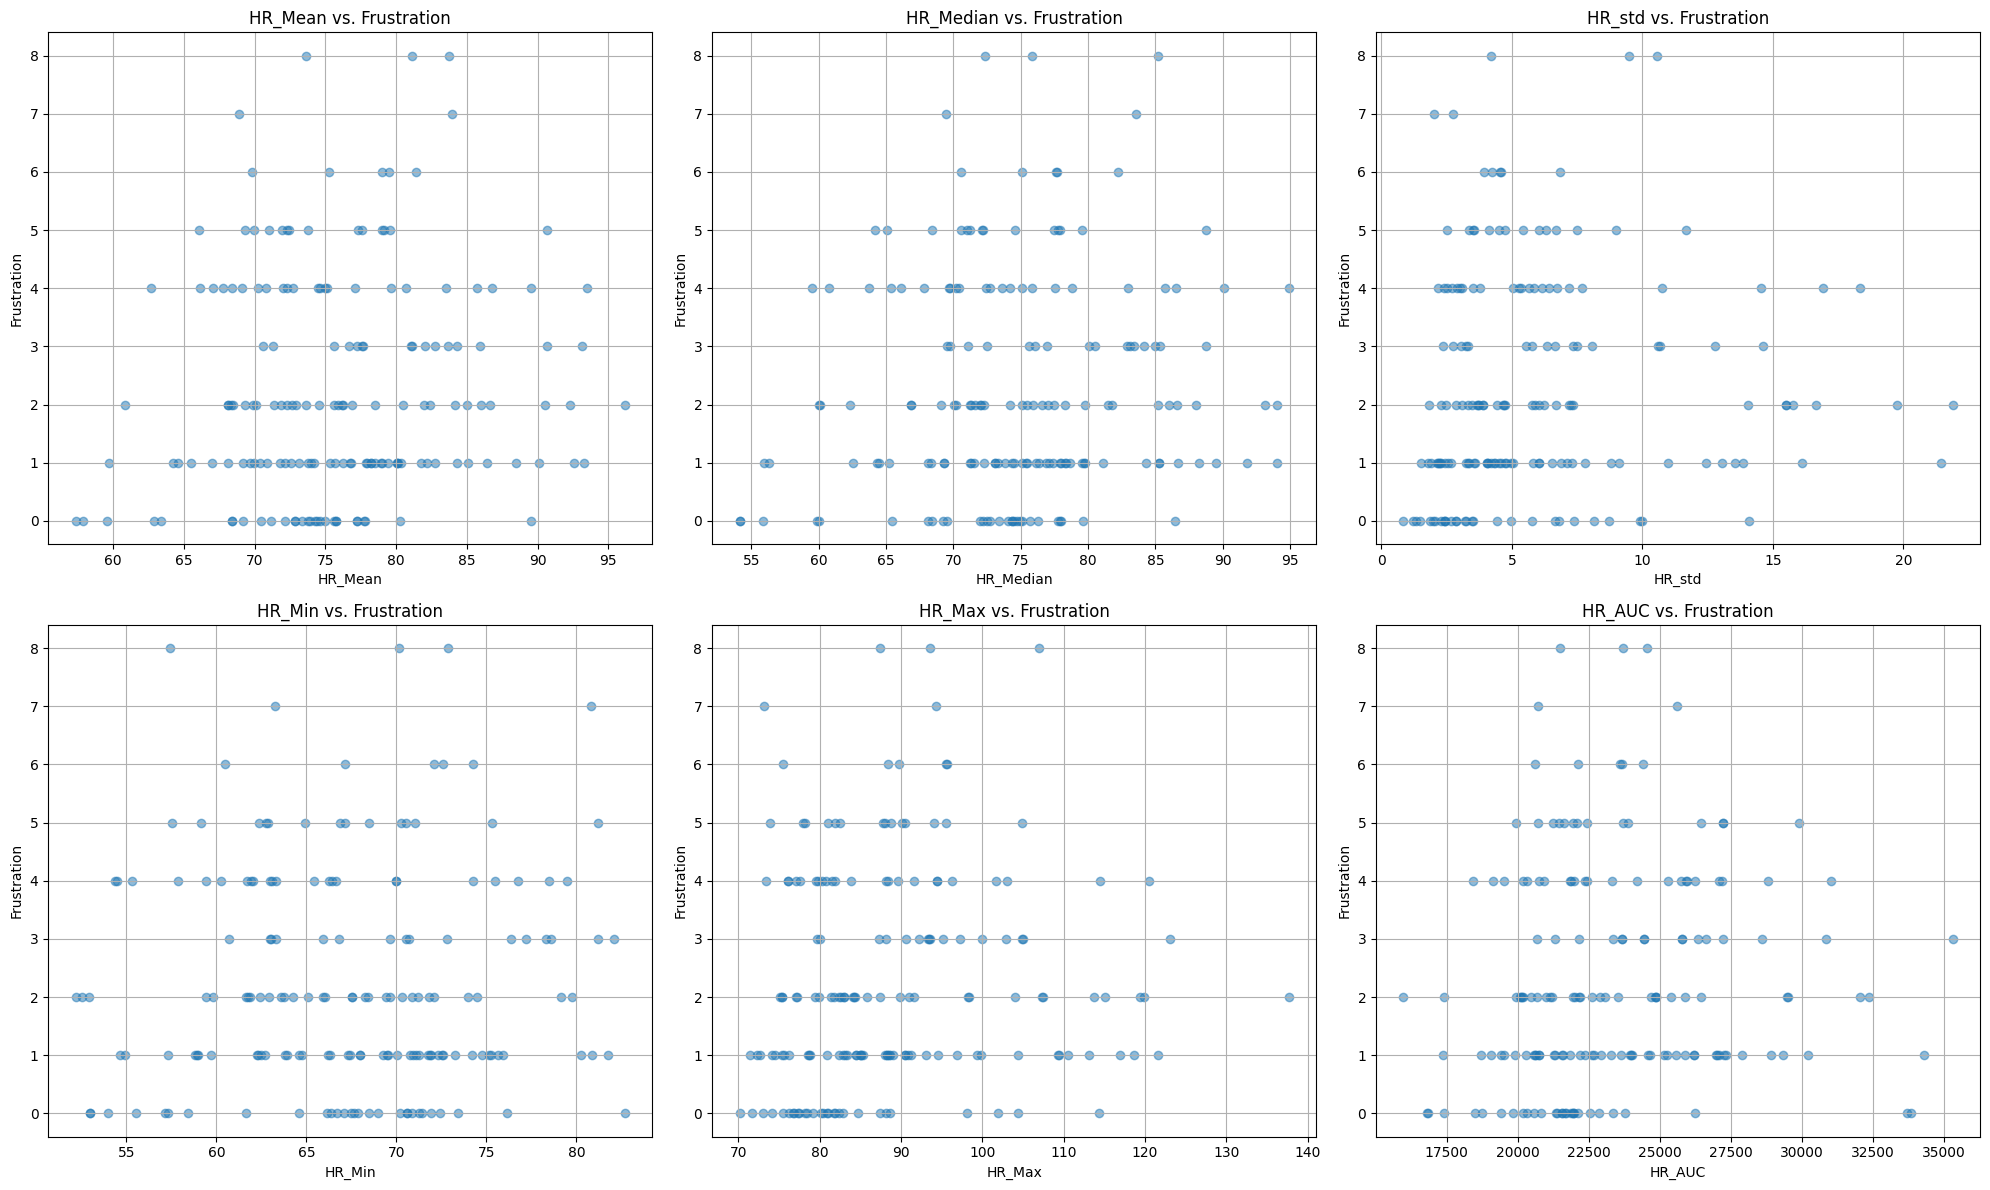

In [205]:
# Extract heart rate related columns and frustration
hr_columns = ['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC']
frustration = df['Frustrated']

# Plot each heart rate attribute against frustration
plt.figure(figsize=(20, 12))

for i, column in enumerate(hr_columns, 1):
    plt.subplot(2, 3, i)
    plt.scatter(df[column], frustration, alpha=0.5)
    plt.xlabel(column)
    plt.ylabel('Frustration')
    plt.title(f'{column} vs. Frustration')
    plt.grid(True)

plt.tight_layout()
plt.show()



# visualization

Frustration is discrete variable. Therefore, each value from 0-10 can be seen as a discrete and separated value. We can thus view this as a classification problem. Therefore, we will attempt to fit two classification models to the data.

# Models

## Classification

In [182]:
# Display the first few rows of the dataframe
print(df.head())

# Display information about the dataframe
print(df.info())

X = df.drop(["Unnamed: 0",'Frustrated',"Individual","Puzzler","Cohort","Phase","Round"], axis=1)

X

   Unnamed: 0    HR_Mean  HR_Median    HR_std  HR_Min  HR_Max     HR_AUC  \
0           0  77.965186      78.00  3.345290   73.23   83.37  22924.945   
1           1  70.981097      70.57  2.517879   67.12   78.22  21930.400   
2           2  73.371959      73.36  3.259569   67.88   80.22  21647.085   
3           3  78.916822      77.88  4.054595   72.32   84.92  25258.905   
4           4  77.322226      74.55  6.047603   70.52   90.15  23890.565   

     Round   Phase  Individual  Puzzler  Frustrated Cohort  
0  round_3  phase3           1        1           1   D1_1  
1  round_3  phase2           1        1           5   D1_1  
2  round_3  phase1           1        1           0   D1_1  
3  round_2  phase3           1        1           1   D1_1  
4  round_2  phase2           1        1           5   D1_1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------

,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC
0,77.965186,78.000,3.345290,73.23,83.37,22924.945
1,70.981097,70.570,2.517879,67.12,78.22,21930.400
2,73.371959,73.360,3.259569,67.88,80.22,21647.085
3,78.916822,77.880,4.054595,72.32,84.92,25258.905
4,77.322226,74.550,6.047603,70.52,90.15,23890.565
...,...,...,...,...,...,...
163,73.594539,72.380,9.474556,57.43,93.53,21482.985
164,57.839897,54.130,6.796647,52.97,74.14,16825.740
165,64.237295,65.195,3.589241,58.97,72.63,18691.065
166,70.834320,70.440,2.391160,66.65,76.07,20753.005


In [183]:
y = df['Frustrated']

In [184]:
from sklearn.preprocessing import StandardScaler

numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

# Check mean and standard deviation
print(X[numeric_columns].mean())
print(X[numeric_columns].std())


HR_Mean      2.379049e-16
HR_Median   -7.850863e-16
HR_std      -5.815454e-17
HR_Min      -8.035900e-16
HR_Max      -1.015061e-15
HR_AUC      -4.546628e-16
dtype: float64
HR_Mean      1.00299
HR_Median    1.00299
HR_std       1.00299
HR_Min       1.00299
HR_Max       1.00299
HR_AUC       1.00299
dtype: float64


In [185]:
y.value_counts()

Frustrated
1    45
2    31
0    29
4    23
3    16
5    14
6     5
8     3
7     2
Name: count, dtype: int64

In [186]:
X_R = []
for i in range(14):
    globals()[f'individual_{i}'] = X[(i*12):((i+1)*12)]
    X_R.append(globals()[f'individual_{i}'])

y_R = []

for i in range(14):
    y_R.append(y[(i*12):((i+1)*12)])

In [187]:
# Initialize lists to hold results
y_true = []
y_pred = []

i = 0

X_test = X_R[i]
X_train_p = copy.deepcopy(X_R)
X_train_p.pop(i)

y_test = y_R[i]
y_train_p = copy.deepcopy(y_R)
y_train_p.pop(i)

X_train = pd.concat(X_train_p)
y_train = pd.concat(y_train_p)

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred.append(model.predict(X_test))
y_true.append(y_test.values)

# Calculate accuracy
accuracy = accuracy_score(y_true[0], y_pred[0])
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.1667


## Random Forest

In [188]:
# Initialize lists to hold results
accuracy_RF = []
# Perform LOOCV
for i in range(len(X_R)):
    y_true = []
    y_pred = []
    X_test = X_R[i]
    X_train_p = copy.deepcopy(X_R)
    X_train_p.pop(i)

    y_test = y_R[i]
    y_train_p = copy.deepcopy(y_R)
    y_train_p.pop(i)

    X_train = pd.concat(X_train_p)
    y_train = pd.concat(y_train_p)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred.append(model.predict(X_test))
    y_true.append(y_test.values)

    accuracy_RF.append(accuracy_score(y_true[0], y_pred[0]))

## Logistic Regression

In [189]:
# Initialize lists to hold results
accuracy_LR = []

# Perform LOOCV
for i in range(len(X_R)):
    y_true = []
    y_pred = []
    X_test = X_R[i]
    X_train_p = copy.deepcopy(X_R)
    X_train_p.pop(i)

    y_test = y_R[i]
    y_train_p = copy.deepcopy(y_R)
    y_train_p.pop(i)

    X_train = pd.concat(X_train_p)
    y_train = pd.concat(y_train_p)

    # Initialize and train the model
    model = LogisticRegression(random_state=42, max_iter=100000)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred.append(model.predict(X_test))
    y_true.append(y_test.values)

    accuracy_LR.append(accuracy_score(y_true[0],y_pred[0]))

## Baseline - Classification

In [190]:
# Initialize lists to hold results
accuracy_BL = []
mk1 = []
mk2 = []

# Perform LOOCV
for i in range(len(X_R)):
    y_true = []
    y_pred = []

    y_test = y_R[i]
    y_train_p = copy.deepcopy(y_R)
    y_train_p.pop(i)

    X_train = pd.concat(X_train_p)
    y_train = pd.concat(y_train_p)

    # Initialize and train the model
    class_0 = 0
    class_1 = 0
    for i in range(len(y_train)):
        if y_train.iat[i] > 0.5:
            class_1 += 1
        else:
            class_0 += 1
    
    C1 = False

    if class_1 > class_0:
        C1 = True

    
    if C1 == True:
        y_pred = [pd.DataFrame([1]*len(y_test))]
    else:
        y_pred = [pd.DataFrame([0]*len(y_test))]
            

    # Make predictions
    y_true.append(y_test.values)

    accuracy_BL.append(accuracy_score(y_true[0],y_pred[0]))
    

In [191]:
np.mean(accuracy_BL)

0.26785714285714285

## ANN Regression

3 layers.

Input layer: 64 neurons and uses ReLU activation function.

Hidden layer: 32 neurons and uses ReLU activation function.

Output layer: 1 neuron and uses linear activation function.

In [192]:
# Build the ANN model
ann_model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # For regression, the output layer should have a linear activation function
])

# Compile the model
ann_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
history = ann_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

# Evaluate the model
loss, ann_mse = ann_model.evaluate(X_test, y_test)

# Predictions
y_pred_ann = ann_model.predict(X_test)

print('ANN Regression Mean Squared Error: ', ann_mse)

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.3410 - mean_squared_error: 9.3410 - val_loss: 12.3118 - val_mean_squared_error: 12.3118
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0814 - mean_squared_error: 8.0814 - val_loss: 11.4122 - val_mean_squared_error: 11.4122
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6520 - mean_squared_error: 6.6520 - val_loss: 10.8020 - val_mean_squared_error: 10.8020
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5361 - mean_squared_error: 7.5361 - val_loss: 10.3959 - val_mean_squared_error: 10.3959
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3107 - mean_squared_error: 5.3107 - val_loss: 10.1568 - val_mean_squared_error: 10.1568
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4471 - mean_squared_error: 5.4471 - val_loss: 10.0786 - val_mean_squared_error: 10.0786
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2641 - mean_squared_error: 5.2641 - val_loss: 10.2103 - val_mean_squared_err

## Baseline - Regression

In [193]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Calculate the mean frustration value from the training set
mean_frustration = y_train.mean()
print('Mean Frustration Value (Baseline): ', mean_frustration)

# Use the mean value as the prediction for all test set observations
y_pred_baseline = np.full_like(y_test, mean_frustration)

# Calculate the Mean Squared Error (MSE) for the baseline model
baseline_mse = mean_squared_error(y_test, y_pred_baseline)
print('Baseline Regression Model MSE: ', baseline_mse)

# Print comparison
print(f'ANN Model MSE: {ann_mse}')


Mean Frustration Value (Baseline):  2.2884615384615383
Baseline Regression Model MSE:  7.166666666666667
ANN Model MSE: 8.022761344909668


In [194]:
np.mean(accuracy_BL)

0.26785714285714285

In [195]:
np.mean(accuracy_RF)

0.14880952380952378

# Analysis

## Check for normality

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


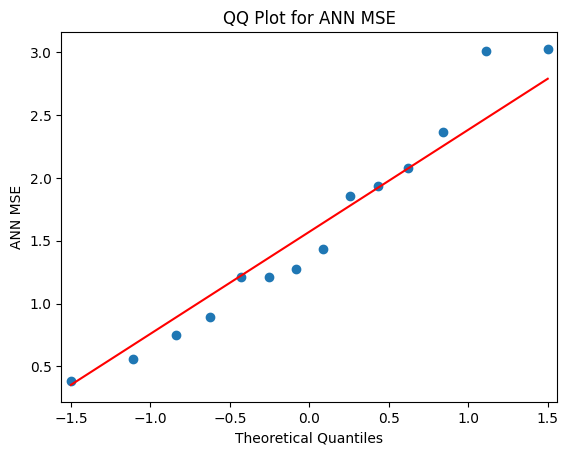

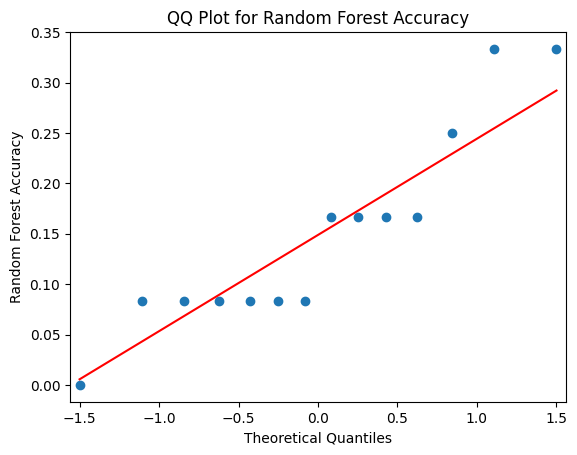

In [197]:
from sklearn.model_selection import KFold
# ANN model
ann_model = Sequential()
ann_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(1, activation='linear'))

# Compile the model
ann_model.compile(loss='mean_squared_error', optimizer='adam')

kf = KFold(n_splits=14, shuffle=False)

# Train the model
mse_list = []
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    ann_model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, verbose=0)
    
    y_pred = ann_model.predict(X_val_fold)
    mse = mean_squared_error(y_val_fold, y_pred)
    mse_list.append(mse)



# Random Forest accuracy data
accuracy_RF

# Generate theoretical quantiles
theoretical_quantiles = np.linspace(0, 1, len(mse_list))

# Create QQ plot for ANN MSE
sm.qqplot(np.array(mse_list), line='s')
plt.title('QQ Plot for ANN MSE')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('ANN MSE')
plt.show()

# Create QQ plot for Random Forest accuracy
sm.qqplot(np.array(accuracy_RF), line='s')
plt.title('QQ Plot for Random Forest Accuracy')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Random Forest Accuracy')
plt.show()

The QQ-plots look questionable. We use non-parametric bootstrapping to generate more points and check again.

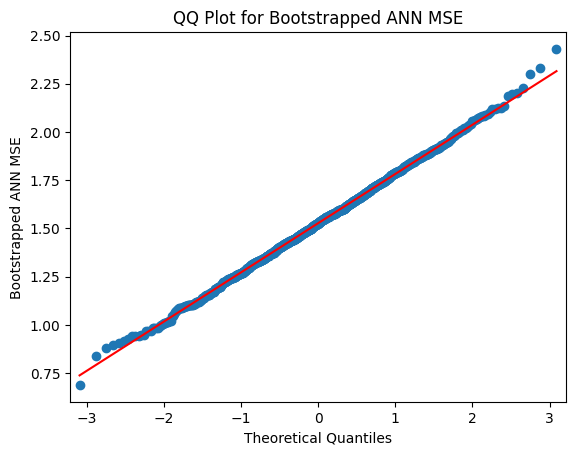

In [ ]:
# Perform bootstrapping
individuals = df['Individual'].unique()
bootstrapped_mse = []
n_iterations = 1000
n_size = int(len(individuals) * 0.8)

for i in range(n_iterations):
    sample = np.random.choice(mse_list, n_size, replace=True)
    bootstrapped_mse.append(np.mean(sample))

# Create QQ plot for bootstrapped ANN MSE
sm.qqplot(np.array(bootstrapped_mse), line='s')
plt.title('QQ Plot for Bootstrapped ANN MSE')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Bootstrapped ANN MSE')
plt.show()

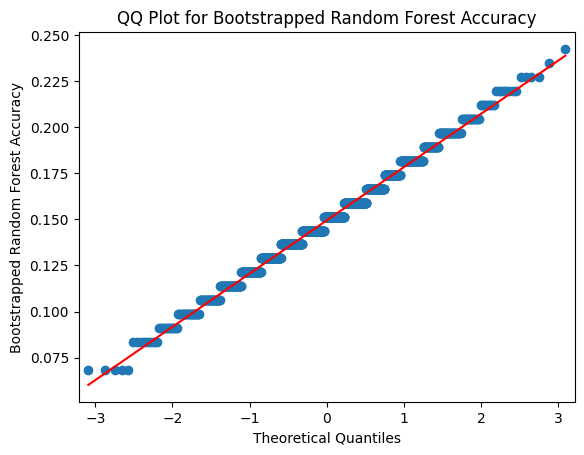

In [ ]:
# Perform bootstrapping
bootstrapped_rf_accuracy = []
n_iterations = 1000
n_size = int(len(individuals) * 0.8)

for i in range(n_iterations):
    sample = np.random.choice(accuracy_RF, n_size, replace=True)
    bootstrapped_rf_accuracy.append(np.mean(sample))

# Create QQ plot for bootstrapped Random Forest Accuracy
sm.qqplot(np.array(bootstrapped_rf_accuracy), line='s')
plt.title('QQ Plot for Bootstrapped Random Forest Accuracy')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Bootstrapped Random Forest Accuracy')
plt.show()


ANN looks normally distributed but Random Forest does not.

In [ ]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test on bootstrapped ANN MSE
stat_ann, p_ann = shapiro(bootstrapped_mse)
print('Shapiro-Wilk Test for Bootstrapped ANN MSE:')
print('Statistics=%.3f, p=%.3f' % (stat_ann, p_ann))

# Interpret the result
alpha = 0.05
if p_ann > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

# Perform Shapiro-Wilk test on bootstrapped Random Forest Accuracy
stat_rf, p_rf = shapiro(bootstrapped_rf_accuracy)
print('Shapiro-Wilk Test for Bootstrapped Random Forest Accuracy:')
print('Statistics=%.3f, p=%.3f' % (stat_rf, p_rf))

# Interpret the result
if p_rf > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


Shapiro-Wilk Test for Bootstrapped ANN MSE:
Statistics=0.999, p=0.968
Sample looks Gaussian (fail to reject H0)
Shapiro-Wilk Test for Bootstrapped Random Forest Accuracy:
Statistics=0.993, p=0.000
Sample does not look Gaussian (reject H0)


In [199]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test on bootstrapped ANN MSE
stat_ann, p_ann = shapiro(mse_list)
print('Shapiro-Wilk Test for ANN MSE:')
print('Statistics=%.3f, p=%.3f' % (stat_ann, p_ann))

# Interpret the result
alpha = 0.05
if p_ann > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

# Perform Shapiro-Wilk test on bootstrapped Random Forest Accuracy
stat_rf, p_rf = shapiro(accuracy_RF)
print('Shapiro-Wilk Test for Random Forest Accuracy:')
print('Statistics=%.3f, p=%.3f' % (stat_rf, p_rf))

# Interpret the result
if p_rf > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


Shapiro-Wilk Test for ANN MSE:
Statistics=0.944, p=0.478
Sample looks Gaussian (fail to reject H0)
Shapiro-Wilk Test for Random Forest Accuracy:
Statistics=0.867, p=0.038
Sample does not look Gaussian (reject H0)


Shapiro wilk test confirms this.

## Statistical Tests

## ANN

In [ ]:
y_test = np.array(y_test).flatten()
y_pred_ann = np.array(y_pred_ann).flatten()


# Calculate residuals for ANN and baseline
residuals_ann = y_test - y_pred_ann
residuals_baseline = y_test - y_pred_baseline


# Perform paired t-test for ANN vs Baseline MSE
stat_ann, p_ann = ttest_rel(residuals_ann, residuals_baseline)
print('Paired t-test for ANN vs Baseline MSE:')
print('Statistics=%.3f, p=%.3f' % (stat_ann, p_ann))

# Interpret the result
alpha = 0.05
if p_ann > alpha:
    print('Sample distributions are similar (fail to reject H0)')
else:
    print('Sample distributions are different (reject H0)')

Paired t-test for ANN vs Baseline MSE:
Statistics=-4.730, p=0.001
Sample distributions are different (reject H0)


## RF

In [ ]:
# Assuming baseline_accuracy is calculated as before
mean_frustration_class = round(y_train.mean())
baseline_accuracy = [mean_frustration_class] * len(accuracy_RF)

# Perform Wilcoxon signed-rank test for Random Forest vs Baseline
stat_rf, p_rf = wilcoxon(accuracy_RF, baseline_accuracy)
print('Wilcoxon signed-rank test for Random Forest Accuracy:')
print('Statistics=%.3f, p=%.3f' % (stat_rf, p_rf))

# Interpret the result
alpha = 0.05
if p_rf > alpha:
    print('Sample distributions are similar (fail to reject H0)')
else:
    print('Sample distributions are different (reject H0)')

Wilcoxon signed-rank test for Random Forest Accuracy:
Statistics=0.000, p=0.000
Sample distributions are different (reject H0)
